# Hierarchical GANs for morphological and geometric trees

## Imports

In [1]:
import numpy as np

# Keras
from keras.models import Sequential
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, merge
from keras.models import Model
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM

# Other
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import pickle

%matplotlib inline

# Local
import McNeuron
import models2 as models
import train2 as train
import batch_utils
import data_transforms

Using Theano backend.


## Example neuron

/Users/pavanramkumar/anaconda2/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


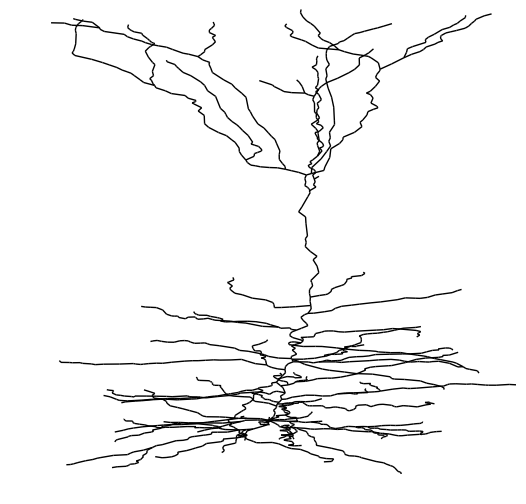

In [2]:
neuron_list = McNeuron.visualize.get_all_path(os.getcwd()+"/Data/Pyramidal/chen")
neuron = McNeuron.Neuron(file_format = 'swc', input_file=neuron_list[50])
McNeuron.visualize.plot_2D(neuron)

## Training

### Load Data

In [3]:
training_data = pickle.load(open("/Users/pavanramkumar/Dropbox/HG-GAN/03-Data/synthetic_Two_segment_model_Different_directions_Parent_distance_n20_parent_id.p", "rb"))
#training_data = pickle.load(open("/Users/pavanramkumar/Dropbox/HG-GAN/03-Data/train4.p", "rb"))

In [4]:
print training_data['morphology']['n20'].shape
print training_data['geometry']['n20'].shape

(50000, 19)
(50000, 19, 3)


In [5]:
import data_transforms
v = np.zeros([training_data['morphology']['n40'].shape[0],39])
for i in range(training_data['morphology']['n40'].shape[0]):
    a = data_transforms.decode_prufer(list(training_data['morphology']['n40'][i,:]))
    a = np.array(a)
    v[i,:] = a[1:]
training_data['morphology']['n40'] = v

KeyError: 'n40'

### Global parameters

In [5]:
n_levels = 1
n_nodes = [20]

input_dim = 100

n_epochs = 5
batch_size = 16
n_batch_per_epoch = np.floor(training_data['morphology']['n20'].shape[0]/batch_size).astype(int)
d_iters = 100
lr_discriminator =  0.001
lr_generator = 0.001
train_loss = 'wasserstein_loss'

rule = 'none'
train_one_by_one = False
weight_constraint = [-0.03, 0.03]

### Run

In [ ]:
geom_model, cond_geom_model, morph_model, cond_morph_model, disc_model, gan_model = \
    train.train_model(training_data=training_data,
                      n_levels=n_levels,
                      n_nodes=n_nodes,
                      input_dim=input_dim,
                      n_epochs=n_epochs,
                      batch_size=batch_size,
                      n_batch_per_epoch=n_batch_per_epoch,
                      d_iters=d_iters,
                      lr_discriminator=lr_discriminator,
                      lr_generator=lr_generator,
                      weight_constraint=weight_constraint,
                      rule=rule,
                      train_one_by_one=train_one_by_one,
                      train_loss=train_loss,
                      verbose=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 19, 3)         0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 19, 20)        0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 20, 43)        0           input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 1, 860)        0           lambda_1[0][0]          

In [8]:
level=0
g_model = geom_model[level]
m_model = morph_model[level]
cg_model = geom_model[level]
cm_model = geom_model[level]
d_model = disc_model[level]
stacked_model = gan_model[level]

NameError: name 'geom_model' is not defined

In [ ]:
d_model.trainable = False
stacked_model.get_config()

In [ ]:
stacked_model.summary()

In [ ]:
noise_code = np.random.randn(1,1,100)

if rule == 'gmd':
    locations_gen = geom_model[0].predict(noise_code)
    softmax_gen = np.squeeze(cond_morph_model[0].predict([noise_code, locations_gen]))
elif rule == 'mgd':
    softmax_gen = morph_model[0].predict(noise_code)
    locations_gen = cond_geom_model[0].predict([noise_code, softmax_gen])
    softmax_gen = np.squeeze(softmax_gen)

In [ ]:
plt.imshow(softmax_gen, interpolation='none', cmap='Greys')
plt.colorbar()
plt.show()

In [ ]:
neuron_object = train.plot_example_neuron(locations_gen, softmax_gen)
neuron_object = McNeuron.Neuron(file_format='only list of nodes', input_file = neuron_object.nodes_list)

In [ ]:
plt.plot(softmax_gen.argmax(axis=1))
plt.ylim([0, 20])
plt.show()

In [ ]:
neuron_object.parent_index

In [ ]:
McNeuron.visualize.plot_dedrite_tree(neuron_object)

In [ ]:
print np.max(training_data['geometry']['n20'][0, :, :]), np.min(training_data['geometry']['n20'][0, :, :])
print locations_gen.max(), locations_gen.min()

In [ ]:
neuron_object = McNeuron.Neuron(file_format='only list of nodes', input_file = neuron_object.nodes_list)
neuron_object.fit()
features = neuron_object.features
features.keys()

In [ ]:
import pprint as pp
pp.pprint(features['branch_angle_segment'])

In [ ]:
for ex in range(2200, 2300):
    input_code = dict()
    input_code['morphology'] = training_data['morphology']['n20'][ex, :]
    input_code['geometry'] = np.squeeze(training_data['geometry']['n20'][ex, :, :])
    neuron_object = data_transforms.make_swc_from_prufer_and_locations(input_code)
    neuron_object = McNeuron.Neuron(file_format='only list of nodes', input_file = neuron_object.nodes_list)
    McNeuron.visualize.plot_2D(neuron_object)
    McNeuron.visualize.plot_dedrite_tree(neuron_object)
    plt.show()
    plt.plot(training_data['morphology']['n20'][ex, :])
    plt.show()